In [1]:
from pygmo import hypervolume
import csv
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
#### Modified from Pau's code
def compute_pareto_front(population):
    #print(np.shape(np.array(population)))
    #print(population)
    pop_size = len(population)
    obj_num = 2

    domination_counter = [0] * pop_size

    for i in range(pop_size):
        for j in range(i+1, pop_size):
            # check each objective for dominance
            dominate = [0] * obj_num
            for k in range(obj_num):
                if population[i][k] > population[j][k]:
                    dominate[k] = 1
                elif population[i][k] < population[j][k]:
                    dominate[k] = -1
            if -1 not in dominate and 1 in dominate:
                domination_counter[i] += 1
            elif -1 in dominate and 1 not in dominate:
                domination_counter[j] += 1

    pareto_solutions = []
    for i in range(len(domination_counter)):
        if domination_counter[i] == 0:
            pareto_solutions.append(population[i])
    return pareto_solutions

def compute_hv(population):
    array_archs = np.zeros((len(population), 2))
    for i in range(len(population)):
        array_archs[i] = population[i]
    hv_object = hypervolume(array_archs)
    hv = hv_object.compute([1.1,1.1])/1.1**2
    return hv

In [3]:
#### Read data from the appropriate csv file
np.set_printoptions(threshold=np.inf)

# set to: true - to read results for fibre stiffness model run
#         false - to read results for truss model run
fibre_stiffness = False

# set to: true - if Epsilon MOEA was used
#         false - if AOS MOEA was used
eps_moea = False

run_number = 0 # starts from 0

filepath = 'C:\\SEAK Lab\\SEAK Lab Github\\KD3M3\\Truss_AOS\\result\\'
if eps_moea:
    fileloc = 'Epsilon MOEA Runs\\'
    if fibre_stiffness:
        filename = 'Fibre Stiffness code run results\\EpsilonMOEA_emoea' + str(run_number) + '_fibrestiffness_fullpop.csv'
    else: 
        filename = 'Truss code run results\\EpsilonMOEA_emoea' + str(run_number) + '_trussstiffness_fullpop.csv'
else:
    fileloc = 'AOS MOEA Runs\\'
    if fibre_stiffness:
        filename = 'Feas and Stab False\\Fibre Stiffness code run results\\AOSMOEA_constraint_adaptive' + str(run_number) + '_fibrestiffness_fullpop.csv'
    else: 
        filename = 'Feas and Stab False\\Truss code run results\\AOSMOEA_constraint_adaptive' + str(run_number) + '_trussstiffness_fullpop.csv' 

full_filepath = filepath + fileloc + filename

with open(full_filepath,newline='') as csvfile:
    data = [row for row in csv.reader(csvfile)]
    designs = ["" for x in range(len(data)-1)]
    num_func_evals = np.zeros(len(data)-1)
    pen_obj1 = np.zeros(len(data)-1)
    pen_obj2 = np.zeros(len(data)-1)
    feas_scores = np.zeros(len(data)-1)
    stab_scores = np.zeros(len(data)-1)
    for x in range(len(data)-1):
        designs[x] = data[x+1][0]
        num_func_evals[x] = int(data[x+1][1])
        pen_obj1[x] = float(data[x+1][2])
        pen_obj2[x] = float(data[x+1][3])
        feas_scores[x] = float(data[x+1][4])
        stab_scores[x] = float(data[x+1][5])
        
n_des = len(designs)
des_array = np.zeros((n_des,36))
for x in range(n_des):
    current_des = designs[x]
    for y in range(36):
        des_array[x][y] = int(current_des[y])
        
#des_list = list(designs)

In [4]:
#### Compute true objectives
def compute_true_objectives(pen_obj1, pen_obj2, feas_score, stab_score, fib_stiff):
    pen_fac = 1
    if fib_stiff:
        pen_fac = 1.5
    pen = (np.log10(np.absolute(feas_score)) + np.log10(np.absolute(stab_score)))/2
    obj1 = 15*(pen_obj1 + pen_fac*pen)
    obj2 = -8500*(pen_obj2 + pen_fac*pen)
    return obj1, obj2

obj1_true = np.zeros(n_des)
obj2_true = np.zeros(n_des)
for i in range(n_des):
    obj1_true_current, obj2_true_current = compute_true_objectives(pen_obj1[i], pen_obj2[i], feas_scores[i], stab_scores[i], fibre_stiffness)
    obj1_true[i] = obj1_true_current
    obj2_true[i] = obj2_true_current

In [5]:
#### Sort num_fun_evals (and obj1 & obj2) in ascending order
n_func_evals = num_func_evals
sort_indices = np.argsort(n_func_evals)
pen_obj1_sorted = list(pen_obj1[sort_indices])
pen_obj2_sorted = list(pen_obj2[sort_indices])
feas_scores_sorted = list(feas_scores[sort_indices])
stab_scores_sorted = list(stab_scores[sort_indices])
true_obj1_sorted = list(obj1_true[sort_indices])
true_obj2_sorted = list(obj2_true[sort_indices])

designs_sorted = []
for i in range(len(sort_indices)):
    designs_sorted.append(designs[sort_indices[i]])

pen_obj1_max_fullrun = np.max(pen_obj1_sorted)
pen_obj1_min_fullrun = np.min(pen_obj1_sorted)
pen_obj2_max_fullrun = np.max(pen_obj2_sorted)
pen_obj2_min_fullrun = np.min(pen_obj2_sorted)

pen_objs_maxmin = np.zeros((2,2))
pen_objs_maxmin[0][0] = pen_obj1_max_fullrun
pen_objs_maxmin[0][1] = pen_obj1_min_fullrun
pen_objs_maxmin[1][0] = pen_obj2_max_fullrun
pen_objs_maxmin[1][1] = pen_obj2_min_fullrun

print('Penalized objectives maximum and minimum values for all runs')

print(pen_obj1_max_fullrun)
print(pen_obj1_min_fullrun)
print(pen_obj2_max_fullrun)
print(pen_obj2_min_fullrun)

true_obj1_max_fullrun = np.max(true_obj1_sorted)
true_obj1_min_fullrun = np.min(true_obj1_sorted)
true_obj2_max_fullrun = np.max(true_obj2_sorted)
true_obj2_min_fullrun = np.min(true_obj2_sorted)

true_objs_maxmin = np.zeros((2,2))
true_objs_maxmin[0][0] = true_obj1_max_fullrun
true_objs_maxmin[0][1] = true_obj1_min_fullrun
true_objs_maxmin[1][0] = true_obj2_max_fullrun
true_objs_maxmin[1][1] = true_obj2_min_fullrun

print('True objectives maximum and minimum values for all runs')

print(true_obj1_max_fullrun)
print(true_obj1_min_fullrun)
print(true_obj2_max_fullrun)
print(true_obj2_min_fullrun)

#print(n_func_evals)
#nfe_list = list(n_func_evals)
#nfe_list.sort()
#print(nfe_list)
#print(obj1_sorted)
#print(obj2_sorted)

nfe_list_sorted = list(n_func_evals[sort_indices])
#print(nfe_list)

Penalized objectives maximum and minimum values for all runs
8.072890858584344
0.0
8.006281567614943
-0.7428896877791852
True objectives maximum and minimum values for all runs
1.798253455808796
0.0
6989.99497903536
0.04020054770759174


In [6]:
#### Compute and plot hypervolume values
max_func_evals = nfe_list_sorted[-1]
ref_point = [1.1,1.1]

def get_feasibility_score(feas_array, index):
    return feas_array[index]

def get_stability_score(stab_array, index):
    return stab_array[index]

def get_true_objectives(obj1_true, obj2_true, index):
    return obj1_true[index], obj2_true[index]

def get_design(design_array, index):
    return design_array[index]

def find_last_index(val,search_list):
    for i in range(len(search_list)-1,-1,-1):
        if search_list[i] == val:
            last_index = i
            break
    return last_index

def find_last_index2(val,search_list):
    return len(search_list) - search_list[::-1].index(val) - 1

def find_closest_index(val,search_list):
    val_diff = np.array(search_list) - val
    #print(val_diff[510:520])
    closest_index = np.argmin(np.abs(val_diff))
    #print(closest_index)
    return closest_index

def rectify_objectives(objs1_sorted, objs2_sorted, num_evals_list, val, maxmin_pen_objs, maxmin_true_objs):
    obj1_max_overall = maxmin_pen_objs[0][0]
    obj1_min_overall = maxmin_pen_objs[0][1]
    obj2_max_overall = maxmin_pen_objs[1][0]
    obj2_min_overall = maxmin_pen_objs[1][1]
    
    true_obj1_max_overall = maxmin_true_objs[0][0]
    true_obj1_min_overall = maxmin_true_objs[0][1]
    true_obj2_max_overall = maxmin_true_objs[1][0]
    true_obj2_min_overall = maxmin_true_objs[1][1]
    
    objs = []
    objs_true = []
    #print(val)
    if val==0.0:
        n_eval_ind_last = find_last_index2(val, num_evals_list)
    else:
        n_eval_ind_last = find_closest_index(val, num_evals_list)
    
    #print('n_eval_ind_last = ' + str(n_eval_ind_last))
    
    obj1_current = objs1_sorted[:n_eval_ind_last]
    obj2_current = objs2_sorted[:n_eval_ind_last]
    n_total = len(obj1_current)
    
    ## Determining the pareto front from the current population
    pop_current = list(zip(obj1_current,obj2_current))
    pareto_current = compute_pareto_front(pop_current)
    pareto_current_unique = list(set(pareto_current))
    print('pareto front of the current population')
    print(pareto_current_unique)
    feas_array_pareto = []
    stab_array_pareto = []
    true_obj_pareto = []
    designs_pareto = []
    for pareto_obj_array in pareto_current_unique:
        pareto_index = objs1_sorted.index(pareto_obj_array[0])
        #pareto_index2 = objs2_sorted.index(pareto_obj_array[1])
        #print('pareto_indices')
        #print(pareto_index)
        #print(pareto_index2)
        feas_pareto = get_feasibility_score(feas_scores_sorted, pareto_index)
        stab_pareto = get_stability_score(stab_scores_sorted, pareto_index)
        feas_array_pareto.append(feas_pareto)
        stab_array_pareto.append(stab_pareto)
        #print(pareto_obj_array)
        #print(feas_pareto)
        #print(stab_pareto)
        
        obj1_true, obj2_true = compute_true_objectives(pareto_obj_array[0], pareto_obj_array[1], feas_pareto, stab_pareto, fibre_stiffness)
        #obj1_true, obj2_true = get_true_objectives(true_obj1_sorted, true_obj2_sorted, pareto_index)
        true_obj_pareto.append([obj1_true, obj2_true])
        designs_pareto.append(get_design(designs_sorted, pareto_index))
    print('feasibility score(s)')
    print(feas_array_pareto)
    print('stability score(s)')
    print(stab_array_pareto)
    print('true objective value(s)')
    print(true_obj_pareto)
    print('designs')
    print(designs_pareto)
        
    ## Normalizing both objectives, second objective is normalized so the max negative value is 0
    n_pareto_all = len(pareto_current)
    n_pareto = len(pareto_current_unique)
    obj1_pareto = [objs[0] for objs in pareto_current_unique]
    obj2_pareto = [objs[1] for objs in pareto_current_unique]
    
    obj1_rectified = np.zeros(n_pareto)
    obj2_rectified = np.zeros(n_pareto)
    
    true_obj1_pareto = [objs[0] for objs in true_obj_pareto]
    true_obj2_pareto = [objs[1] for objs in true_obj_pareto]
    
    true_obj1_rectified = np.zeros(n_pareto)
    true_obj2_rectified = np.zeros(n_pareto)
    
    for i in range(n_pareto):
        obj1_rectified[i] = (obj1_pareto[i] - obj1_min_overall)/(obj1_max_overall - obj1_min_overall)
        obj2_rectified[i] = (obj2_pareto[i] - obj2_min_overall)/(obj2_max_overall - obj2_min_overall)
        objs.insert(i, [obj1_rectified[i], obj2_rectified[i]])
        
        true_obj1_rectified[i] = (true_obj1_pareto[i] - true_obj1_min_overall)/(true_obj1_max_overall - true_obj1_min_overall)
        true_obj2_rectified[i] = (true_obj2_max_overall - true_obj2_pareto[i])/(true_obj2_max_overall - true_obj2_min_overall)
        objs_true.insert(i, [true_obj1_rectified[i], true_obj2_rectified[i]])
        
    #obj1_rect_list = list(obj1_rectified)
    #obj2_rect_list = list(obj2_rectified)
    
    #print('Normalized Objectives')
    #print(obj1_rect_list)
    #print(obj2_rect_list)
    
    return objs, objs_true, n_pareto, n_pareto_all, n_total

### PENALIZED OBJECTIVES HYPERVOLUME COMPUTATION

print('Starting hypervolume computation for penalized objectives')
pop_size = int(find_last_index2(0, nfe_list_sorted))
n_iter_jump = 50
n_iter = math.floor(max_func_evals/n_iter_jump)
hypervols = np.zeros(n_iter+1)
hypervols_true = np.zeros(n_iter+1)
nfe_array = np.zeros(n_iter+1)
n_pareto_archs = np.zeros(n_iter+1)
n_pareto_all_archs = np.zeros(n_iter+1)
n_total_archs = np.zeros(n_iter+1)
objs0, objs_true0, n_pareto_0, n_pareto_all_0, n_total_0 = rectify_objectives(pen_obj1_sorted, pen_obj2_sorted, nfe_list_sorted, 0.0, pen_objs_maxmin, true_objs_maxmin)
n_pareto_archs[0] = n_pareto_0
n_pareto_all_archs[0] = n_pareto_all_0
n_total_archs[0] = n_total_0
hv = hypervolume(objs0)
hypervols[0] = hv.compute(ref_point)/1.1**2
hv_true = hypervolume(objs_true0)
hypervols_true[0] = hv_true.compute(ref_point)/1.1**2
print('hypervolume')
print(hypervols[0])
print('true objectives hypervolume')
print(hypervols_true[0])
print('\n')
objs = [] 

print('Starting loop')
count = 1
for i in range(pop_size, int(max_func_evals), n_iter_jump):
    #n_eval_ind_last = find_last_index(math.floor((max_func_evals/10)*(i)), nfe_list)
    print('iter = ' + str(i))
    
    objs_i, objs_truei, n_pareto_i, n_pareto_all_i, n_total_i = rectify_objectives(pen_obj1_sorted, pen_obj2_sorted, nfe_list_sorted, i, pen_objs_maxmin, true_objs_maxmin)
    print('hypervolume objectives')
    print(objs_i)
    n_pareto_archs[count] = n_pareto_i
    n_total_archs[count] = n_total_i
    n_pareto_all_archs[count] = n_pareto_all_i
    hv = hypervolume(objs_i)
    hypervols[count] = hv.compute(ref_point)/1.1**2
    hv_true = hypervolume(objs_truei)
    hypervols_true[count] = hv_true.compute(ref_point)/1.1**2
    print('hypervolume')
    print(hypervols[count])
    print('true objectives hypervolume')
    print(hypervols_true[count])
    print('\n')
    nfe_array[count] = i
    count += 1
    
objs_last, objs_truelast, n_pareto_last, n_pareto_all_last, n_total_last = rectify_objectives(pen_obj1_sorted, pen_obj2_sorted, nfe_list_sorted, max_func_evals, pen_objs_maxmin, true_objs_maxmin)
n_pareto_archs[-1] = n_pareto_last
n_pareto_all_archs[-1] = n_pareto_all_last
n_total_archs[-1] = n_total_last
hv = hypervolume(objs_last)
hypervols[-1] = hv.compute(ref_point)/1.1**2
hv_true = hypervolume(objs_truelast)
hypervols_true[-1] = hv_true.compute(ref_point)/1.1**2
print('hypervolume')
print(hypervols[-1])
print('true objectives hypervolume')
print(hypervols_true[-1])
print('\n')
nfe_array[-1] = max_func_evals

#print(np.max(objs_last[:,1]))

Starting hypervolume computation for penalized objectives
pareto front of the current population
[(7.947434351573772, 7.400984440651879), (7.933246282145649, 7.44170167710494), (7.929451588419261, 7.501817830820692), (7.9311761102134115, 7.483903536792137)]
feasibility score(s)
[1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16]
stability score(s)
[1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.27891709473448323, 4486.771222486554], [0.0660960533126298, 4140.674712635531], [0.009175647416816979, 3629.6874060516398], [0.03504347432907284, 3781.958905294361]]
designs
['111100101001010111101101011100111111', '101000001011011011100111001011011111', '100101101001010000111011000101101111', '011011010100010111110111101010001010']
hypervolume
0.016455635089470035
true objectives hypervolume
0.6635707530297915


Starting loop
iter = 98
pareto front of the current population
[(7.947434351573772, 7.400984440651879), (7.933246282145649, 7.4417016771049

pareto front of the current population
[(7.961502046992558, 7.266590352550821), (7.973160898912063, 7.196937354532274), (7.949572644575191, 7.3046558725349815), (7.969431773571586, 7.2403549421796995), (7.9533900994553335, 7.297552310802205), (7.964800455182906, 7.2631063937044145), (7.949192743367016, 7.32894131313005), (7.964881448241989, 7.2597548044655795), (7.971025439257554, 7.238051387255843), (7.966264053696092, 7.257458190295947), (7.960342469561931, 7.2827429776414485), (7.941417445524542, 7.330060688310793), (7.928839878591473, 7.38251977250513), (7.939421146453055, 7.33175936960221)]
feasibility score(s)
[1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16]
stability score(s)
[1.0, 1.0, 1.0, 1.0,

pareto front of the current population
[(7.95399501245761, 7.26645694846428), (7.9629886199488125, 7.244182754097082), (7.941417445524542, 7.330060688310793), (7.939421146453055, 7.33175936960221), (7.928839878591473, 7.38251977250513), (7.969431773571586, 7.2403549421796995), (7.971025439257554, 7.238051387255843), (7.949572644575191, 7.3046558725349815), (7.950002414314637, 7.2794491069874), (7.93276489990603, 7.382300819967784), (7.949159982969869, 7.327083829008442), (7.95993902756705, 7.248530881367188), (7.938818611578257, 7.374578404756908), (7.9711649500378, 7.196496201984132)]
feasibility score(s)
[1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

pareto front of the current population
[(7.945148971106409, 7.299095591963325), (7.960583682176218, 7.217092908152536), (7.939206261583332, 7.352226085723387), (7.95993902756705, 7.248530881367188), (7.95399501245761, 7.26645694846428), (7.950002414314637, 7.2794491069874), (7.941417445524542, 7.330060688310793), (7.939421146453055, 7.33175936960221), (7.944557577776176, 7.32095033374418), (7.935991832348995, 7.366961998329996), (7.972337510534643, 7.162713975472738), (7.928839878591473, 7.376270403082703), (7.967834276709934, 7.187644089887218), (7.938858921384992, 7.362742950335747), (7.938730346872805, 7.364960731208466), (7.985619222210655, 7.106487528116725), (7.983729093205994, 7.151232117704772)]
feasibility score(s)
[1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1.3877787807814457e-16, 1

pareto front of the current population
[(0.04759900120246822, -0.6427249660257893), (0.021295159205162503, -0.5742030674696164), (0.00756366494420424, -0.5152278033986795), (0.013420213035556428, -0.5523349172814555)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.7139850180370233, 5463.162211219209], [0.31942738807743754, 4880.726073491739], [0.1134549741630636, 4379.436328888775], [0.2013031955333464, 4694.8467968923715]]
designs
['101000001000000011000100001010010101', '101000001000000011000101001000011101', '101100001000000011000101001010011101', '101000001000000011000101001010011101']
hypervolume objectives
[[0.0058961531917471185, 0.011448481099468855], [0.0026378604118645057, 0.019280297000195127], [0.0009369214915325387, 0.026020965613188257], [0.0016623800904338978, 0.021779750897006043]]
hypervolume
0.9887112524331426
true objectives hypervolume
0.7281222933901256


iter = 1298
pareto front of the current populati

pareto front of the current population
[(0.00756366494420424, -0.5152278033986795), (0.021971489294024305, -0.5757715846347758), (0.013420213035556428, -0.5523349172814555), (0.013420213035556442, -0.5523349172814556), (0.05713283393456745, -0.6427249660257894), (0.04759900120246822, -0.6427249660257893), (0.021295159205162503, -0.5742030674696164), (0.01290115720650323, -0.521249696269579)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.1134549741630636, 4379.436328888775], [0.32957233941036457, 4894.058469395594], [0.2013031955333464, 4694.8467968923715], [0.20130319553334663, 4694.846796892372], [0.8569925090185118, 5463.16221121921], [0.7139850180370233, 5463.162211219209], [0.31942738807743754, 4880.726073491739], [0.19351735809754844, 4430.622418291421]]
designs
['101100001000000011000101001010011101', '101000001000000111000101001010011101', '101000001000000011000101001010011101

pareto front of the current population
[(0.00756366494420424, -0.5152278033986795), (0.01646864342103375, -0.5706154278456519), (0.021971489294024305, -0.5757715846347758), (0.013420213035556428, -0.5523349172814555), (0.013420213035556442, -0.5523349172814556), (0.05713283393456745, -0.6427249660257894), (0.04759900120246822, -0.6427249660257893), (0.021295159205162503, -0.5742030674696164), (0.01290115720650323, -0.521249696269579)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.1134549741630636, 4379.436328888775], [0.24702965131550628, 4850.231136688041], [0.32957233941036457, 4894.058469395594], [0.2013031955333464, 4694.8467968923715], [0.20130319553334663, 4694.846796892372], [0.8569925090185118, 5463.16221121921], [0.7139850180370233, 5463.162211219209], [0.31942738807743754, 4880.726073491739], [0.19351735809754844, 4430.622418291421]]
designs
['10110000100000001100

pareto front of the current population
[(0.00756366494420424, -0.5152278033986795), (0.04077368892908659, -0.5903606941956654), (0.055207560768044034, -0.6709175431531227), (0.01646864342103375, -0.5706154278456519), (0.021971489294024305, -0.5757715846347758), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257893), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.1134549741630636, 4379.436328888775], [0.6116053339362988, 5018.065900663156], [0.8281134115206605, 5702.799116801543], [0.24702965131550628, 4850.231136688041], [0.32957233941036457, 4894.058469395594], [0.20130319553334663, 4694.846796892372], [0.2013031955333464, 4694.8467968923715], [0.7139850180370233, 5463.162211219209], [0.31942738807743

pareto front of the current population
[(0.00756366494420424, -0.5152278033986795), (0.04077368892908659, -0.5903606941956654), (0.055207560768044034, -0.6709175431531227), (0.01646864342103375, -0.5706154278456519), (0.021971489294024305, -0.5757715846347758), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.1134549741630636, 4379.436328888775], [0.6116053339362988, 5018.065900663156], [0.8281134115206605, 5702.799116801543], [0.24702965131550628, 4850.231136688041], [0.32957233941036457, 4894.058469395594], [0.20130319553334663, 4694.846796892372], [0.2013031955333464, 4694.8467968923715], [0.7139850180370233, 5463.16221121921], [0.319427388077437

pareto front of the current population
[(0.00756366494420424, -0.5152278033986795), (0.04077368892908659, -0.5903606941956654), (0.055207560768044034, -0.6709175431531227), (0.01646864342103375, -0.5706154278456519), (0.05103795082599638, -0.6658562256346676), (0.021971489294024305, -0.5757715846347758), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.1134549741630636, 4379.436328888775], [0.6116053339362988, 5018.065900663156], [0.8281134115206605, 5702.799116801543], [0.24702965131550628, 4850.231136688041], [0.7655692623899457, 5659.777917894675], [0.32957233941036457, 4894.058469395594], [0.20130319553334663, 4694.846796892372], [0.20

pareto front of the current population
[(0.00756366494420424, -0.5152278033986795), (0.04077368892908659, -0.5903606941956654), (0.055207560768044034, -0.6709175431531227), (0.01646864342103375, -0.5706154278456519), (0.05103795082599638, -0.6658562256346676), (0.021971489294024305, -0.5757715846347758), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.1134549741630636, 4379.436328888775], [0.6116053339362988, 5018.065900663156], [0.8281134115206605, 5702.799116801543], [0.24702965131550628, 4850.231136688041], [0.7655692623899457, 5659.777917894675], [0.32957233941036457, 4894.058469395594], [0.20130319553334663, 4694.846796892372], [0.20

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.8281134115206605, 5702.799116801543], [0.7655692623899457, 5659.777917894675], [0.0, 4523.141075423633], [0.24702965131550628, 4850.231136688041], [0.553745222863323, 5099.7672698316355], [0.32957233941036457, 4894.058469395594], [0.24312899444910285, 4

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.8281134115206605, 5702.799116801543], [0.7655692623899457, 5659.777917894675], [0.0, 4523.141075423633], [0.24702965131550628, 4850.231136688041], [0.553745222863323, 5099.7672698316355], [0.32957233941036457, 4894.058469395594], [0.24312899444910285, 4

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.8281134115206605, 5702.799116801543], [0.7655692623899457, 5659.777917894675], [0.0, 4523.141075423633], [0.24702965131550628, 4850.231136688041], [0.553745222863323, 5099.7672698316355], [0.32957233941036457, 4894.058469395594], [0.24312899444910285, 4

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.02427542377913409, -0.5915075730073454), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.8281134115206605, 5702.799116801543], [0.7655692623899457, 5659.777917894675], [0.0, 4523.141075423633], [0.24702965131550628, 4850.231136688041], [0.553745222863323, 5099.7672698316355], [0.32957233

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.02427542377913409, -0.5915075730073454), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.8281134115206605, 5702.799116801543], [0.7655692623899457, 5659.777917894675], [0.0, 4523.141075423633], [0.24702965131550628, 4850.231136688041], [0.553745222863323, 5099.7672698316355], [0.32957233

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.07847773924678969, -0.678767861330215), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.026258547220221827, -0.59528749403815), (0.02427542377913409, -0.5915075730073454), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.8281134115206605, 5702.799116801543], [0.7655692623899457, 5659.777917894675], [0.0, 4523.141

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.07847773924678969, -0.678767861330215), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.026258547220221827, -0.59528749403815), (0.02427542377913409, -0.5915075730073454), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.8281134115206605, 5702.799116801543], [0.7655692623899457, 5659.777917894675], [0.0, 4523.141

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.07847773924678969, -0.678767861330215), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.026258547220221827, -0.59528749403815), (0.02427542377913409, -0.5915075730073454), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.8281134115206605, 5702.799116801543], [0.7655692623899457, 5659.777917894675], [0.0, 4523.141

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.07847773924678969, -0.678767861330215), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.026258547220221827, -0.59528749403815), (0.02427542377913409, -0.5915075730073454), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.8281134115206605, 5702.799116801543], [0.7655692623899457, 5659.777917894675], [0.0, 4523.141

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.07847773924678969, -0.678767861330215), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.026258547220221827, -0.59528749403815), (0.02427542377913409, -0.5915075730073454), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.8281134115206605, 5702.799116801543], [0.7655692623899457, 5659.777917894675], [0.0, 4523.141

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.07847773924678969, -0.678767861330215), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.026258547220221827, -0.59528749403815), (0.02427542377913409, -0.5915075730073454), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.8281134115206605, 5702.799116801543], [0.7655692623899457, 5659.777917894675], [0.0, 4523.141

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.07847773924678969, -0.678767861330215), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.026258547220221827, -0.59528749403815), (0.02427542377913409, -0.5915075730073454), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective value(s)
[[0.8281134115206605, 5702.799116801543], [0.7655692623899457, 5659.777917894675], [0.0, 4523.141

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.07847773924678969, -0.678767861330215), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.026258547220221827, -0.59528749403815), (0.05348777341480682, -0.670496082958724), (0.02427542377913409, -0.5915075730073454), (0.05677934361918136, -0.6769796195884005), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.07847773924678969, -0.678767861330215), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.026258547220221827, -0.59528749403815), (0.05348777341480682, -0.670496082958724), (0.02427542377913409, -0.5915075730073454), (0.05677934361918136, -0.6769796195884005), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true objective

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.01646864342103375, -0.5706154278456519), (0.036916348190888196, -0.5999726199801925), (0.07847773924678969, -0.678767861330215), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.013420213035556428, -0.5523349172814555), (0.04759900120246822, -0.6427249660257894), (0.026258547220221827, -0.59528749403815), (0.05348777341480682, -0.670496082958724), (0.02427542377913409, -0.5915075730073454), (0.05677934361918136, -0.6769796195884005), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0,

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257894), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.07847773924678969, -0.678767861330215), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
stability score(s)
[

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.03395756880292042, -0.5953904619644037), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05082022708682265, -0.65041994005876), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.07847773924678969, -0.678767861330215), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.03395756880292042, -0.5953904619644037), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05082022708682265, -0.65041994005876), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.07847773924678969, -0.678767861330215), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.03395756880292042, -0.5953904619644037), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05082022708682265, -0.65041994005876), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.07847773924678969, -0.678767861330215), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.03395756880292042, -0.5953904619644037), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.03395756880292042, -0.5953904619644037), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.03395756880292042, -0.5953904619644037), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.03395756880292042, -0.5953904619644037), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.03395756880292042, -0.5953904619644037), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.03395756880292042, -0.5953904619644037), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.03395756880292042, -0.5953904619644037), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.03395756880292042, -0.5953904619644037), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.036916348190888196, -0.5999726199801925), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.030831974314698352, -0.6103760600512953), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.030831974314698352, -0.6103760600512953), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.030831974314698352, -0.6103760600512953), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibility score(s)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

pareto front of the current population
[(0.055207560768044034, -0.6709175431531227), (0.02129515920516251, -0.5742030674696165), (0.04759900120246822, -0.6427249660257898), (0.05850082271525501, -0.6794006998092108), (0.05082022708682265, -0.65041994005876), (0.058541675889758164, -0.718808561638583), (0.05103795082599638, -0.6658562256346676), (0.0, -0.5321342441674862), (0.08954541194700422, -0.7428896877791852), (0.013420213035556428, -0.5523349172814555), (0.05348777341480682, -0.670496082958724), (0.05677934361918136, -0.6769796195884005), (0.01646864342103375, -0.5706154278456519), (0.02427542377913409, -0.5915075730073454), (0.021971489294024305, -0.5757715846347758), (0.01620859962994019, -0.5549019286897726), (0.02896790878635085, -0.6207590411129784), (0.013420213035556442, -0.5523349172814556), (0.026258547220221827, -0.59528749403815), (0.045308183932197287, -0.6267782481226436), (0.021295159205162503, -0.5742030674696164), (0.01060636497461925, -0.535865851909617)]
feasibi

In [7]:
# Hypervolume values after jump
highest_hv_jump = 0
jump_index = 0
for i in range(len(hypervols)-1):
    hv_jump_current = hypervols[i+1] - hypervols[i]
    if hv_jump_current > highest_hv_jump:
        highest_hv_jump = hv_jump_current
        jump_index = i
        
hypervols_after_jump = hypervols[jump_index+1:]
nfe_array_after_jump = nfe_array[jump_index+1:]

print(jump_index)
print(highest_hv_jump)
#print(nfe_array)

14
0.948330264693693


Plotting


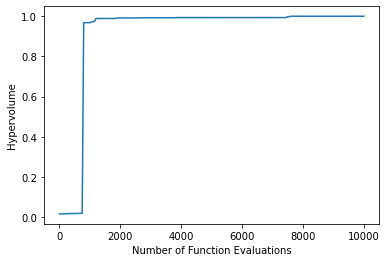

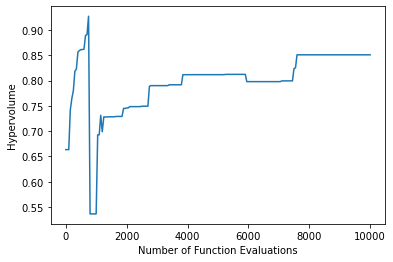

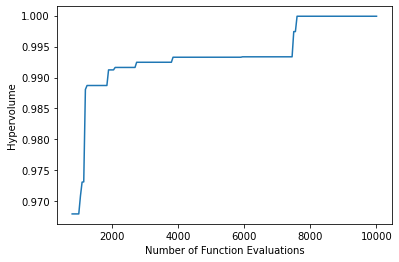

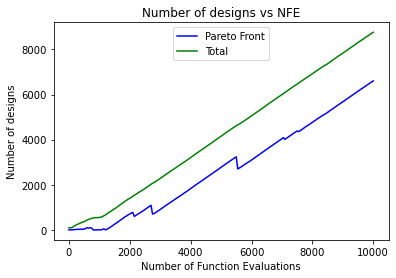

In [8]:
### PLOTTTING FOR PENALIZED OBJECTIVES

print('Plotting')
#### Plot hypervolume vs NFE
fig1 = plt.figure(1)
plt.plot(nfe_array,hypervols)
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
#plt.title('Hypervolume vs NFE')
plt.show()
#fig1.savefig('HV_plot_eps_truss_' + str(run_number) + '.png')

#### Plot true objectves hypervolume vs NFE
fig1a = plt.figure(1)
plt.plot(nfe_array,hypervols_true)
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
#plt.title('True Objectives Hypervolume vs NFE')
plt.show()
#fig1a.savefig('HV_plot_eps_truss_' + str(run_number) + '.png')

#### Plot hypervolume vs NFE after hypervolume jump
fig2 = plt.figure(1)
plt.plot(nfe_array_after_jump,hypervols_after_jump)
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
#plt.title('Hypervolume vs NFE after jump')
plt.show()
#fig2.savefig('HV_plot_post_jump_eps_truss_' + str(run_number) + '.png')

#### Plot number of designs in the pareto front vs NFE
fig3 = plt.figure(2)
plt.plot(nfe_array,n_pareto_all_archs,'b-',label='Pareto Front')
plt.plot(nfe_array,n_total_archs,'g-',label='Total')
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Number of designs')
plt.title('Number of designs vs NFE')
plt.legend(loc='upper center')
plt.show()
#fig3.savefig('num_designs_vs_nfe_eps_truss_' + str(run_number) + '.png')

In [ ]:
### TRUE OBJECTIVES HYPERVOLUME COMPUTATION

def rectify_objectives_true(objs1_sorted, objs2_sorted, num_evals_list, val, true_obj1_max_overall, true_obj1_min_overall, true_obj2_max_overall, true_obj2_min_overall):
    objs = []
    objs_true = []
    #print(val)
    if val==0.0:
        n_eval_ind_last = find_last_index2(val, num_evals_list)
    else:
        n_eval_ind_last = find_closest_index(val, num_evals_list)
    
    #print('n_eval_ind_last = ' + str(n_eval_ind_last))
    
    obj1_current = objs1_sorted[:n_eval_ind_last]
    obj2_current = objs2_sorted[:n_eval_ind_last]
    n_total = len(obj1_current)
    
    obj2_current_pf = np.multiply(obj2_current,-1)
    
    ## Determining the pareto front from the current population
    pop_current = list(zip(obj1_current,obj2_current_pf))
    pareto_current = compute_pareto_front(pop_current)
    pareto_current_unique = list(set(pareto_current))
    print('pareto front of the current population')
    print(pareto_current_unique)
    feas_array_pareto = []
    stab_array_pareto = []
    true_obj_pareto = []
    designs_pareto = []
    for pareto_obj_array in pareto_current_unique:
        pareto_index = objs1_sorted.index(pareto_obj_array[0])
        #pareto_index2 = objs2_sorted.index(pareto_obj_array[1])
        #print('pareto_indices')
        #print(pareto_index)
        #print(pareto_index2)
        feas_pareto = get_feasibility_score(feas_scores_sorted, pareto_index)
        stab_pareto = get_stability_score(stab_scores_sorted, pareto_index)
        feas_array_pareto.append(feas_pareto)
        stab_array_pareto.append(stab_pareto)
        #print(pareto_obj_array)
        #print(feas_pareto)
        #print(stab_pareto)
        
        designs_pareto.append(get_design(designs_sorted, pareto_index))
    print('feasibility score(s)')
    print(feas_array_pareto)
    print('stability score(s)')
    print(stab_array_pareto)
    print('designs')
    print(designs_pareto)
        
    ## Normalizing both objectives, second true objective is to be maximized thus the smallest value is assigned normalized score of 1
    n_pareto_all = len(pareto_current)
    n_pareto = len(pareto_current_unique)
    obj1_pareto = [objs[0] for objs in pareto_current_unique]
    obj2_pareto = [-objs[1] for objs in pareto_current_unique]
    
    obj1_rectified = np.zeros(n_pareto)
    obj2_rectified = np.zeros(n_pareto)
    
    for i in range(n_pareto):
        obj1_rectified[i] = (obj1_pareto[i] - true_obj1_min_overall)/(true_obj1_max_overall - true_obj1_min_overall)
        obj2_rectified[i] = (true_obj2_max_overall - obj2_pareto[i])/(true_obj2_max_overall - true_obj2_min_overall)
        objs.insert(i, [obj1_rectified[i], obj2_rectified[i]])
        
    obj1_rect_list = list(obj1_rectified)
    obj2_rect_list = list(obj2_rectified)
    
    #print('Normalized Objectives')
    #print(obj1_rect_list)
    #print(obj2_rect_list)
    
    return objs, n_pareto, n_pareto_all, n_total

print('Starting hypervolume computation for true objectives')
pop_size = int(find_last_index2(0, nfe_list_sorted))
n_iter_jump = 50
n_iter = math.floor(max_func_evals/n_iter_jump)
hypervols_true = np.zeros(n_iter+1)
nfe_array = np.zeros(n_iter+1)
n_pareto_archs_true = np.zeros(n_iter+1)
n_pareto_all_archs_true = np.zeros(n_iter+1)
n_total_archs_true = np.zeros(n_iter+1)
objs0, n_pareto_0, n_pareto_all_0, n_total_0 = rectify_objectives_true(true_obj1_sorted, true_obj2_sorted, nfe_list_sorted, 0.0, true_obj1_max_fullrun, true_obj1_min_fullrun, true_obj2_max_fullrun, true_obj2_min_fullrun)
n_pareto_archs_true[0] = n_pareto_0
n_pareto_all_archs_true[0] = n_pareto_all_0
n_total_archs_true[0] = n_total_0
hv = hypervolume(objs0)
hypervols_true[0] = hv.compute(ref_point)/1.1**2
print('hypervolume')
print(hypervols_true[0])
print('\n')
objs = [] 

print('Starting loop')
count = 1
for i in range(pop_size, int(max_func_evals), n_iter_jump):
    #n_eval_ind_last = find_last_index(math.floor((max_func_evals/10)*(i)), nfe_list)
    #print('iter = ' + str(i))
    
    objs_i, n_pareto_i, n_pareto_all_i, n_total_i = rectify_objectives_true(true_obj1_sorted, true_obj2_sorted, nfe_list_sorted, i, true_obj1_max_fullrun, true_obj1_min_fullrun, true_obj2_max_fullrun, true_obj2_min_fullrun)
    print('hypervolume objectives')
    print(objs_i)
    n_pareto_archs_true[count] = n_pareto_i
    n_total_archs_true[count] = n_total_i
    n_pareto_all_archs_true[count] = n_pareto_all_i
    hv = hypervolume(objs_i)
    hypervols_true[count] = hv.compute(ref_point)/1.1**2
    print('hypervolume')
    print(hypervols_true[count])
    print('\n')
    nfe_array[count] = i
    count += 1
    
objs_last, n_pareto_last, n_pareto_all_last, n_total_last = rectify_objectives_true(true_obj1_sorted, true_obj2_sorted, nfe_list_sorted, max_func_evals, true_obj1_max_fullrun, true_obj1_min_fullrun, true_obj2_max_fullrun, true_obj2_min_fullrun)
n_pareto_archs_true[-1] = n_pareto_last
n_pareto_all_archs_true[-1] = n_pareto_all_last
n_total_archs_true[-1] = n_total_last
hv = hypervolume(objs_last)
hypervols_true[-1] = hv.compute(ref_point)/1.1**2
print('hypervolume')
print(hypervols_true[-1])
print('\n')
nfe_array[-1] = max_func_evals

In [ ]:
### PLOTTTING FOR TRUE OBJECTIVES

print('Plotting')
#### Plot hypervolume vs NFE
fig4 = plt.figure(1)
plt.plot(nfe_array,hypervols_true)
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
plt.title('Hypervolume vs NFE')
plt.show()
#fig4.savefig('HV_plot_eps_truss_' + str(run_number) + '.png')

#### Plot number of designs in the pareto front vs NFE
fig5 = plt.figure(2)
plt.plot(nfe_array,n_pareto_all_archs_true,'b-',label='Pareto Front')
plt.plot(nfe_array,n_total_archs_true,'g-',label='Total')
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Number of designs')
plt.title('Number of designs vs NFE')
plt.legend(loc='upper center')
plt.show()
#fig5.savefig('num_designs_vs_nfe_eps_truss_' + str(run_number) + '.png')

In [ ]:
np.max(hypervols)

In [ ]:
feas_score = 0.40000000000000013
stab_score = 0.7000000000000001
pen_objective_1 = 0.45102622364079553
pen_objective_2 = -0.3209040150315412
pen_fac = 1.5
pen = (np.log10(np.absolute(feas_score)) + np.log10(np.absolute(stab_score)))/2
obj1 = 15*(pen_objective_1 + pen_fac*pen)
obj2 = -8500*(pen_objective_2 + pen_fac*pen)
print(obj1)
print(obj2)